# **Enhancing Writing Accuracy: BERT-Based Grammatical Error Correction for Digital Literacy**

### Name: Del Castillo, Christian Joaquin R.
### Course: BSIT 402I
### Date: November 2025



---



# **1: INSTALL LIBRARIES**

In [ ]:
!pip install transformers datasets torch

In [ ]:
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


This line of code is a **shell command** that installs or upgrades essential libraries for NLP and deep learning workflows in Python environments like Colab. It ensures that the latest versions of key packages are available, including **`transformers`** for pre-trained models like BERT and fine-tuning tools, **`datasets`** for efficient dataset loading and processing, **`evaluate`** for calculating metrics such as accuracy, precision, recall, and F1-score, **`scikit-learn`** for machine learning utilities and preprocessing, **`torch`** as the core deep learning framework, **`pandas`** for handling tabular data, **`numpy`** for numerical computations, and **`seaborn`** for enhanced data visualization. Running this command helps ensure that your environment has **up-to-date packages**, reducing compatibility issues and providing access to the latest features for model training and analysis.



---



# **2: IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

This code **imports key Python libraries for data analysis and visualization**. `pandas as pd` is used to handle tabular data such as CSV files and to perform data manipulation. `numpy as np` provides tools for efficient numerical computations and array operations. `matplotlib.pyplot as plt` enables creating basic plots and visualizations, while `seaborn as sns`, built on Matplotlib, allows for **enhanced statistical visualizations** with simpler syntax. Finally, `warnings.filterwarnings('ignore')` suppresses unnecessary warning messages, keeping the output clean. In short, this step **prepares the environment for effective data processing and plotting**.




---



In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from datasets import Dataset as HFDataset
import random

This code **imports essential libraries and modules for machine learning, NLP, and dataset handling**. `torch` provides the core PyTorch framework for building and training deep learning models. From `transformers`, `AutoTokenizer` and `AutoModelForSequenceClassification` enable loading pre-trained models and tokenizers, while `Trainer`, `TrainingArguments`, and `DataCollatorWithPadding` facilitate training, evaluation, and dynamic batch padding. From `sklearn`, `train_test_split` splits datasets into training, validation, and test sets, and metrics like `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `classification_report`, and `confusion_matrix` are used to assess model performance. `datasets.Dataset` (aliased as `HFDataset`) converts pandas DataFrames into Hugging Face Dataset format for compatibility with the Trainer, and `random` is used to set seeds for reproducibility. In short, this setup provides **all the tools needed to prepare data, fine-tune a BERT model, and evaluate its performance**.




---



In [ ]:
# MOUNT GOOGLE DRIVE TO SAVE MODELS AND RESULTS
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")
print("Your files will be saved to: /content/drive/MyDrive/")


Mounted at /content/drive
Google Drive mounted successfully!
Your files will be saved to: /content/drive/MyDrive/


I mounted my Google Drive in Colab so I can save models, results, and other files directly to my Drive. By importing `drive` from `google.colab` and running `drive.mount('/content/drive')`, I made my Google Drive accessible within Colab just like a local folder. The `print` statements let me confirm that the mount was successful and show me where my files will be stored (`/content/drive/MyDrive/`). In short, this step lets me **persistently save my trained models and experiment outputs** outside of Colab’s temporary environment.




---



In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


This code **sets up reproducibility and selects the computing device** for model training. By using `random.seed(42)` and `np.random.seed(42)`, it fixes the random number generators for Python and NumPy, ensuring consistent results across runs, while `torch.manual_seed(42)` does the same for PyTorch, making model initialization and training deterministic. The line `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")` checks for GPU availability and uses it for faster computation if present; otherwise, it defaults to the CPU. Finally, `print("Using device:", device)` confirms which device will be used. In short, this setup ensures **consistent results** and allows the model to run on the most efficient hardware available.



---



# **3: LOAD DATA**

In [ ]:
from google.colab import files
print("Please upload your Grammar Correction.csv file")
uploaded = files.upload()

Please upload your Grammar Correction.csv file


Saving Grammar Correction.csv to Grammar Correction.csv


This code snippet allows you to **upload your dataset** (`Grammar-Correction.csv`) into the Colab environment. By importing `files` from `google.colab`, the `files.upload()` function opens a file picker so you can select the CSV from your local machine. The uploaded file is then stored in Colab’s temporary environment, making it accessible for reading with pandas or other tools. The `print` statement simply prompts the user about which file to upload. In short, this step **brings your dataset into Colab so it can be processed and used for training**.



---



In [ ]:
df = pd.read_csv('Grammar Correction.csv')
df_clean = df.dropna(subset=['Ungrammatical Statement', 'Standard English']).copy()
df_clean.rename(columns={'Ungrammatical Statement': 'incorrect_text', 'Standard English': 'correct_text'}, inplace=True)

This block of code **loads and cleans your dataset** for further processing. It starts by reading the CSV file into a pandas DataFrame with `df = pd.read_csv('Grammar-Correction.csv')`. Next, `df.dropna(subset=['Ungrammatical Statement', 'Standard English']).copy()` removes any rows where either the ungrammatical or correct sentence is missing, ensuring that only complete data is used, while `.copy()` avoids potential warnings about chained assignments. Finally, `df_clean.rename(columns={'Ungrammatical Statement': 'incorrect_text', 'Standard English': 'correct_text'}, inplace=True)` renames the columns to shorter, more convenient names for easier reference in later steps. In short, this step **prepares a clean, well-labeled dataset** ready for tokenization and model training.




---



In [ ]:
incorrect_samples = df_clean[['incorrect_text']].copy()
incorrect_samples['label'] = 0
incorrect_samples.rename(columns={'incorrect_text': 'text'}, inplace=True)

correct_samples = df_clean[['correct_text']].copy()
correct_samples['label'] = 1
correct_samples.rename(columns={'correct_text': 'text'}, inplace=True)

This code **prepares labeled training samples** for binary classification. It processes the **incorrect sentences** by selecting the `incorrect_text` column, making a copy, assigning a **label of 0**, and renaming the column to `text` to match the model’s expected input format. Similarly, it processes the **correct sentences** by selecting `correct_text`, assigning a **label of 1**, and renaming the column to `text`. In short, this step **creates two separate datasets with consistent column names and binary labels**—0 for ungrammatical sentences and 1 for correct sentences—preparing them for combination and model training.



---



In [ ]:
combined_df = pd.concat([incorrect_samples, correct_samples], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

This code **combines and shuffles the dataset** to prepare it for training. It first merges the incorrect and correct sentence samples using `pd.concat([incorrect_samples, correct_samples], ignore_index=True)`, creating a single DataFrame with a continuous index. Then, `combined_df.sample(frac=1, random_state=42).reset_index(drop=True)` randomly shuffles all rows so that correct and incorrect sentences are mixed, ensuring the model sees a balanced and randomized order during training. The `random_state=42` ensures reproducibility, and `reset_index(drop=True)` keeps the index clean. In short, this step **creates a unified, randomized dataset** ready for splitting into training, validation, and test sets.




---



In [ ]:
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

This code **splits the combined dataset into training, validation, and test sets** while preserving the proportion of correct and incorrect labels. First, `train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)` allocates 70% of the data to `train_df` and 30% to `temp_df`, with `stratify` ensuring both sets maintain the same ratio of 0 (incorrect) and 1 (correct) labels. Then, `train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)` splits the 30% `temp_df` equally into **validation and test sets**, each containing 15% of the total data, again keeping the label distribution consistent. In short, this step **creates properly balanced datasets** for training, validating, and testing the model.




---



In [ ]:
train_dataset = HFDataset.from_pandas(train_df[['text', 'label']])
val_dataset = HFDataset.from_pandas(val_df[['text', 'label']])
test_dataset = HFDataset.from_pandas(test_df[['text', 'label']])

This code **converts the pandas DataFrames into Hugging Face Dataset objects**, which are optimized for use with the `Trainer` API. `HFDataset.from_pandas(train_df[['text', 'label']])` creates the training dataset containing only the `text` and `label` columns, and the same process is applied to create `val_dataset` and `test_dataset` from the validation and test DataFrames. Using Hugging Face Datasets simplifies **tokenization, batching, and feeding data into the model**, while ensuring full compatibility with the `Trainer` and related utilities.




---



# **4: TOKENIZE DATA**

In [ ]:
MODEL_NAME = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

This code **sets up the tokenizer for BERT** using a pre-trained model. The variable `MODEL_NAME = "google-bert/bert-base-uncased"` specifies the BERT variant — a base-sized, uncased model from Google. `AutoTokenizer.from_pretrained(MODEL_NAME)` then loads the corresponding **tokenizer**, which converts raw text into token IDs that BERT can process. In short, this step **prepares the text-processing tool** needed to transform sentences into the input format required by the BERT model.




---



In [ ]:
def tokenize_function(examples, max_length=64):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=max_length)

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/2825 [00:00<?, ? examples/s]

Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

This code **applies tokenization to all datasets** for BERT. The `tokenize_function` is mapped over the training, validation, and test datasets using `.map()`, with `batched=True` to process multiple examples at once efficiently. The original `text` column is removed (`remove_columns=['text']`), leaving only token IDs, attention masks, and labels. As a result, `tokenized_train`, `tokenized_val`, and `tokenized_test` are now **ready-to-use datasets** in the format required by the Hugging Face `Trainer`, with each example represented by fixed-length token sequences.




---



In [ ]:
tokenized_train.set_format('torch')
tokenized_val.set_format('torch')
tokenized_test.set_format('torch')

This code **converts the tokenized datasets into PyTorch tensors**. By calling `.set_format('torch')` on `tokenized_train`, `tokenized_val`, and `tokenized_test`, all input fields—such as `input_ids`, `attention_mask`, and `labels`—are transformed into PyTorch tensors. This ensures compatibility with the Hugging Face `Trainer`, which requires tensor inputs for model training and evaluation. In short, this step **prepares the datasets for seamless use with PyTorch-based workflows**.




---



In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

This line creates a **data collator** to manage **dynamic padding** during training. Using `DataCollatorWithPadding(tokenizer=tokenizer)`, it automatically pads each batch to the **length of the longest sequence within that batch** rather than a fixed maximum length. This reduces unnecessary padding, making training more memory-efficient and faster. In short, the data collator **handles batching and padding automatically**, ensuring that inputs are properly formatted for BERT.



---



# **5: DEFINE METRICS**

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0)
    }

This function **computes evaluation metrics** for the model’s predictions. It takes `eval_pred`, a tuple containing the model’s raw output scores (`logits`) and the true labels (`labels`). Using `np.argmax(logits, axis=-1)`, it converts the logits into predicted class labels by selecting the class with the highest score. The function then calculates **accuracy, precision, recall, and F1-score** based on the predictions and true labels, with `zero_division=0` to safely handle cases where a class has no predicted samples. In short, this function **provides essential metrics** to evaluate how effectively the model distinguishes grammatically correct from incorrect sentences.



---



# **6: EXPERIMENT 1 - BASELINE**

In [ ]:
training_args_exp1 = TrainingArguments(
    output_dir='./results_exp1',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs_exp1',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    warmup_steps=100,
    fp16=False,
    report_to='none',
    save_total_limit=2,
)

This block configures **CPU-friendly training arguments** for Experiment 1 using Hugging Face’s `TrainingArguments`. It sets `output_dir='./results_exp1'` and `logging_dir='./logs_exp1'` to specify where checkpoints and logs are saved, while `eval_strategy='epoch'` and `save_strategy='epoch'` ensure evaluation and checkpointing occur at the end of each epoch. The learning rate is set to `2e-5`, and both `per_device_train_batch_size` and `per_device_eval_batch_size` are reduced to 2 to fit CPU memory constraints. Training is limited to `num_train_epochs=1` for faster testing, and `weight_decay=0.01` provides regularization. Additional settings include `load_best_model_at_end=True` (retaining the best model based on F1), `warmup_steps=100` for gradual learning rate ramp-up, `fp16=False` to disable mixed precision, `report_to='none'` to turn off external logging, and `save_total_limit=2` to keep only the two most recent checkpoints. Overall, this setup **ensures efficient CPU training while maintaining proper evaluation and reproducibility**.



---



In [ ]:
model_exp1 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
trainer_exp1 = Trainer(model=model_exp1, args=training_args_exp1, train_dataset=tokenized_train,
                       eval_dataset=tokenized_val, data_collator=data_collator, compute_metrics=compute_metrics,
                       tokenizer=tokenizer)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This code **sets up the BERT model and the training pipeline** for Experiment 1. It starts by loading a **fresh pre-trained BERT model** configured for binary classification using `AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)`, and moves it to the selected device (GPU if available, otherwise CPU) with `.to(device)`. Next, the Hugging Face `Trainer` is initialized, taking the model, the CPU-friendly training arguments, tokenized training and validation datasets, the `data_collator` for dynamic padding, the `compute_metrics` function for evaluation, and the tokenizer. In short, this step **prepares everything needed to efficiently train and evaluate the BERT model**.




---



In [ ]:
print("Training Experiment 1")
trainer_exp1.train()

Training Experiment 1


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.769200,0.824383,0.790083,0.732095,0.913907,0.812960
2,0.459700,0.933781,0.791736,0.731579,0.920530,0.815249


TrainOutput(global_step=2826, training_loss=0.708063515719166, metrics={'train_runtime': 202.6632, 'train_samples_per_second': 27.879, 'train_steps_per_second': 13.944, 'total_flos': 185822182848000.0, 'train_loss': 0.708063515719166, 'epoch': 2.0})

This code **initiates training for Experiment 1**. By calling `trainer_exp1.train()`, the Hugging Face `Trainer` begins fine-tuning the BERT model on the tokenized training dataset according to the `training_args_exp1`. Throughout training, the Trainer automatically manages **batching, optimization, evaluation, logging, and checkpointing**, ensuring a streamlined workflow. In short, this line **starts the model learning process**, producing a fine-tuned BERT model ready for validation and testing.




---



In [ ]:
print("Evaluating Experiment 1")
val_results_exp1 = trainer_exp1.evaluate(tokenized_val)
test_results_exp1 = trainer_exp1.evaluate(tokenized_test)
print(val_results_exp1)
print(test_results_exp1)

Evaluating Experiment 1


{'eval_loss': 0.9337813854217529, 'eval_accuracy': 0.7917355371900826, 'eval_precision': 0.7315789473684211, 'eval_recall': 0.9205298013245033, 'eval_f1': 0.8152492668621701, 'eval_runtime': 2.9898, 'eval_samples_per_second': 202.352, 'eval_steps_per_second': 101.343, 'epoch': 2.0}
{'eval_loss': 0.9957595467567444, 'eval_accuracy': 0.7871287128712872, 'eval_precision': 0.7289473684210527, 'eval_recall': 0.9141914191419142, 'eval_f1': 0.8111273792093704, 'eval_runtime': 3.4261, 'eval_samples_per_second': 176.877, 'eval_steps_per_second': 88.438, 'epoch': 2.0}


This code **evaluates the fine-tuned BERT model** on both the validation and test datasets. By calling `trainer_exp1.evaluate(tokenized_val)`, it calculates metrics such as accuracy, precision, recall, and F1-score on the **validation set**, offering insight into how well the model learned during training. Similarly, `trainer_exp1.evaluate(tokenized_test)` measures performance on the **test set**, providing an unbiased assessment of the model’s ability to generalize to unseen data. Finally, `print(val_results_exp1)` and `print(test_results_exp1)` display these metrics in detail. In short, this step **checks and reports the model’s effectiveness** on both familiar and new data.




---



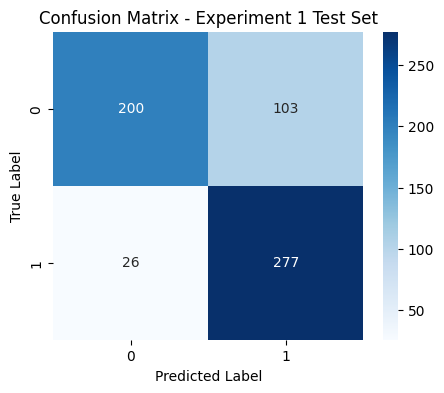

In [ ]:
preds_output = trainer_exp1.predict(tokenized_test)
preds = preds_output.predictions.argmax(axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Experiment 1 Test Set")
plt.show()

In this part of the code, I generate and visualize the confusion matrix for Experiment 1 using the test dataset. I start by using trainer_exp1.predict() to get the model’s predictions, then extract the predicted labels by taking the highest-scoring class and compare them with the true labels from the test set. Using these two sets of values, I compute a confusion matrix to see how many predictions the model got right and where it made mistakes. Finally, I plot the confusion matrix as a heatmap so I can clearly observe the distribution of true positives, true negatives, false positives, and false negatives, allowing me to better understand the model’s performance.



---



In [ ]:
# SAVE EXPERIMENT 1 MODEL TO GOOGLE DRIVE
print("\nSaving Experiment 1 model to Google Drive...")
model_exp1.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_1/')
tokenizer.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_1/')
print("Experiment 1 model saved successfully!")



Saving Experiment 1 model to Google Drive...
Experiment 1 model saved successfully!


I used this code to **save my trained Experiment 1 BERT model and tokenizer to Google Drive**. I called `model_exp1.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_1/')` to save the model’s weights and configuration, and `tokenizer.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_1/')` to store the tokenizer so I can reuse the same text preprocessing later. The `print` statements let me know when the saving process starts and confirm once it’s done. In short, this step lets me **keep my trained model and tokenizer safely stored in Google Drive**, so I can reload them anytime without retraining.




---



# **7: EXPERIMENT 2 - HIGHER LEARNING RATE**

In [ ]:
training_args_exp2 = TrainingArguments(
    output_dir='./results_exp2',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs_exp2',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    warmup_steps=100,
    fp16=False,
    report_to='none',
    save_total_limit=2,
)

This code sets up **training arguments for Experiment 2**, which mirrors Experiment 1 but uses a **higher learning rate** to explore its effect on model performance. The `output_dir='./results_exp2'` and `logging_dir='./logs_exp2'` specify where to save checkpoints and logs. Both `eval_strategy='epoch'` and `save_strategy='epoch'` ensure evaluation and model saving occur at the end of each epoch. The learning rate is increased to `5e-5`, allowing the optimizer to make larger weight updates. Batch sizes for training and evaluation remain at 2 to accommodate CPU memory limits, while `num_train_epochs=1` and `weight_decay=0.01` control the training duration and regularization. Additional settings, including `load_best_model_at_end=True`, `warmup_steps=100`, `fp16=False`, `report_to='none'`, and `save_total_limit=2`, manage model checkpointing, learning rate warmup, CPU compatibility, logging, and checkpoint retention. In short, this configuration **prepares the model for training with a higher learning rate** to assess its impact on performance.




---



In [ ]:
model_exp2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
trainer_exp2 = Trainer(model=model_exp2, args=training_args_exp2, train_dataset=tokenized_train,
                       eval_dataset=tokenized_val, data_collator=data_collator, compute_metrics=compute_metrics,
                       tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This code **prepares the model and trainer for Experiment 2**. It starts by loading a fresh BERT model for binary classification using `AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)` and moves it to the chosen device (`.to(device)`), whether CPU or GPU. Then, the `Trainer(...)` is initialized, linking this model to the Experiment 2 training arguments, the tokenized training and validation datasets, the `data_collator` for dynamic padding, the `compute_metrics` function for performance evaluation, and the tokenizer. In short, this step **sets up an independent training pipeline** so BERT can be fine-tuned using the new hyperparameters for Experiment 2.




---



In [ ]:
print("Training Experiment 2")
trainer_exp2.train()

Training Experiment 2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.747500,0.694061,0.499174,0.499174,1.000000,0.665932
2,0.694500,0.693152,0.499174,0.499174,1.000000,0.665932
3,1.047300,1.002457,0.745455,0.685930,0.903974,0.780000
4,0.988700,0.997741,0.752066,0.688119,0.920530,0.787535


TrainOutput(global_step=5652, training_loss=0.7400563164796714, metrics={'train_runtime': 425.9371, 'train_samples_per_second': 26.53, 'train_steps_per_second': 13.27, 'total_flos': 371644365696000.0, 'train_loss': 0.7400563164796714, 'epoch': 4.0})

This code **begins the training process for Experiment 2**. By calling `trainer_exp2.train()`, the Hugging Face `Trainer` fine-tunes the new BERT model on the tokenized training dataset using the hyperparameters specified in `training_args_exp2`. During training, the Trainer automatically manages **batching, optimization, evaluation, logging, and checkpoint saving**. In short, this line **starts the model learning under the Experiment 2 configuration**.




---



In [ ]:
print("Evaluating Experiment 2")
val_results_exp2 = trainer_exp2.evaluate(tokenized_val)
test_results_exp2 = trainer_exp2.evaluate(tokenized_test)
print(val_results_exp2)
print(test_results_exp2)

Evaluating Experiment 2


{'eval_loss': 0.9977414011955261, 'eval_accuracy': 0.7520661157024794, 'eval_precision': 0.6881188118811881, 'eval_recall': 0.9205298013245033, 'eval_f1': 0.7875354107648725, 'eval_runtime': 3.9019, 'eval_samples_per_second': 155.055, 'eval_steps_per_second': 77.655, 'epoch': 4.0}
{'eval_loss': 1.079820156097412, 'eval_accuracy': 0.7326732673267327, 'eval_precision': 0.6732186732186732, 'eval_recall': 0.9042904290429042, 'eval_f1': 0.7718309859154929, 'eval_runtime': 3.4995, 'eval_samples_per_second': 173.17, 'eval_steps_per_second': 86.585, 'epoch': 4.0}


This code **evaluates the BERT model trained in Experiment 2** on both the validation and test datasets. By calling `trainer_exp2.evaluate(tokenized_val)`, it calculates metrics such as accuracy, precision, recall, and F1-score on the **validation set**, providing insight into how well the model learned during training. Similarly, `trainer_exp2.evaluate(tokenized_test)` evaluates the model on the **test set**, measuring its ability to generalize to unseen data. The results are displayed with `print(val_results_exp2)` and `print(test_results_exp2)`, giving a clear summary of performance. In short, this step **assesses the effectiveness of Experiment 2’s setup** and enables comparison with Experiment 1.




---



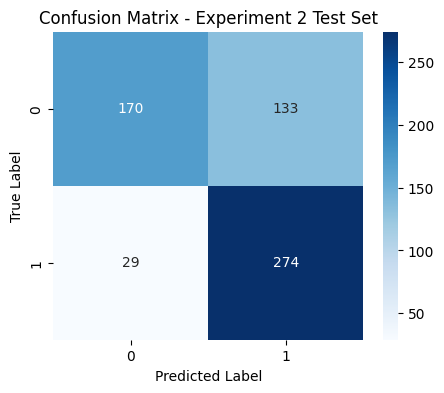

In [ ]:
preds_output = trainer_exp2.predict(tokenized_test)
preds = preds_output.predictions.argmax(axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Experiment 2 Test Set")
plt.show()

In this code, I compute and visualize the confusion matrix for Experiment 2 using the test dataset. I begin by running `trainer_exp2.predict()` to obtain the model's prediction outputs, then extract the predicted labels by selecting the class with the highest probability. I also retrieve the true labels from the test set so I can compare them. Using these predictions and true labels, I generate a confusion matrix to see how well the model classified each category, including where it made errors. Finally, I plot the confusion matrix as a heatmap to clearly visualize the counts of correct and incorrect classifications for Experiment 2.




---



In [ ]:
# After Experiment 2
print("\nSaving Experiment 2 model to Google Drive...")
model_exp2.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_2/')
tokenizer.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_2/')
print("Experiment 2 model saved successfully!")


Saving Experiment 2 model to Google Drive...
Experiment 2 model saved successfully!


In this part of my code, I **save the fine-tuned BERT model and tokenizer from Experiment 2** directly to my Google Drive. I use the `save_pretrained()` function to store the model’s weights and configuration, allowing me to reload it later without going through the training process again. I also save the tokenizer to make sure the same text preprocessing steps are applied whenever I use the model in the future. After everything is saved, I print a confirmation message to verify that both files were successfully stored in my Drive under the folder `/content/drive/MyDrive/BERT_GEC_Models/experiment_2/`.




---



# **8: EXPERIMENT 3 - MORE EPOCHS AND BATCH SIZE**

In [ ]:
training_args_exp3 = TrainingArguments(
    output_dir='./results_exp3',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir='./logs_exp3',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    warmup_steps=100,
    fp16=False,
    report_to='none',
    save_total_limit=2,
)

This block of code defines **training arguments for Experiment 3**, modifying hyperparameters to study their effect on the BERT model’s performance. It specifies `output_dir='./results_exp3'` and `logging_dir='./logs_exp3'` for saving checkpoints and logs, and sets both `eval_strategy` and `save_strategy` to `'epoch'` so the model is evaluated and saved at the end of each epoch. The learning rate is set to 2e-5, while the batch sizes for training and evaluation are increased to 4 to allow more samples per batch. Training is extended to 2 epochs (`num_train_epochs=2`) to give the model more learning time, with weight decay of 0.01 for regularization. Additional settings include `load_best_model_at_end=True` to keep the checkpoint with the highest F1-score, 100 warmup steps, `fp16=False` for CPU compatibility, `report_to='none'`, and `save_total_limit=2` to retain only the two most recent checkpoints. In short, this configuration **examines the impact of larger batch sizes and longer training on model performance**.




---



In [ ]:
model_exp3 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)
trainer_exp3 = Trainer(model=model_exp3, args=training_args_exp3, train_dataset=tokenized_train,
                       eval_dataset=tokenized_val, data_collator=data_collator, compute_metrics=compute_metrics,
                       tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




---



In [ ]:
print("Training Experiment 3")
trainer_exp3.train()

Training Experiment 3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.557000,0.622395,0.780165,0.766562,0.804636,0.785137
2,0.496400,0.691443,0.783471,0.715365,0.940397,0.812589
3,0.419800,0.918471,0.783471,0.719794,0.927152,0.810420
4,0.286500,0.939565,0.806612,0.762040,0.890728,0.821374
5,0.316000,1.128626,0.795041,0.757225,0.867550,0.808642
6,0.163600,1.254606,0.791736,0.760355,0.850993,0.803125


TrainOutput(global_step=4242, training_loss=0.3572227559748375, metrics={'train_runtime': 493.6879, 'train_samples_per_second': 34.333, 'train_steps_per_second': 8.592, 'total_flos': 557466548544000.0, 'train_loss': 0.3572227559748375, 'epoch': 6.0})

This code **initializes the model and trainer for Experiment 3**. It uses `AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)` to load a fresh BERT model configured for binary classification and moves it to the selected device, whether CPU or GPU. The `Trainer(...)` is then set up with this model, the **training arguments specific to Experiment 3**, tokenized training and validation datasets, the `data_collator` for dynamic padding, the `compute_metrics` function for evaluating performance, and the tokenizer. In short, this step **creates a complete training pipeline** for Experiment 3, ready to fine-tune BERT with the updated batch size and number of epochs.




---



In [ ]:
print("Evaluating Experiment 3")
val_results_exp3 = trainer_exp3.evaluate(tokenized_val)
test_results_exp3 = trainer_exp3.evaluate(tokenized_test)
print(val_results_exp3)
print(test_results_exp3)

Evaluating Experiment 3


{'eval_loss': 0.939565122127533, 'eval_accuracy': 0.8066115702479338, 'eval_precision': 0.7620396600566572, 'eval_recall': 0.890728476821192, 'eval_f1': 0.8213740458015267, 'eval_runtime': 2.3952, 'eval_samples_per_second': 252.59, 'eval_steps_per_second': 63.461, 'epoch': 6.0}
{'eval_loss': 1.030655026435852, 'eval_accuracy': 0.7854785478547854, 'eval_precision': 0.7409470752089137, 'eval_recall': 0.8778877887788779, 'eval_f1': 0.8036253776435045, 'eval_runtime': 2.4239, 'eval_samples_per_second': 250.009, 'eval_steps_per_second': 62.709, 'epoch': 6.0}


This code **assesses the performance of Experiment 3’s trained model** on both the validation and test datasets. By calling `trainer_exp3.evaluate(tokenized_val)`, it computes metrics such as accuracy, precision, recall, and F1-score on the **validation set**, providing insight into how well the model learned during training. Similarly, `trainer_exp3.evaluate(tokenized_test)` evaluates the model on the **test set**, measuring its ability to generalize to unseen data. The results are then displayed using `print(val_results_exp3)` and `print(test_results_exp3)`, giving a clear summary of the model’s effectiveness. In short, this step **allows comparison of Experiment 3’s performance** with the outcomes from Experiments 1 and 2.




---



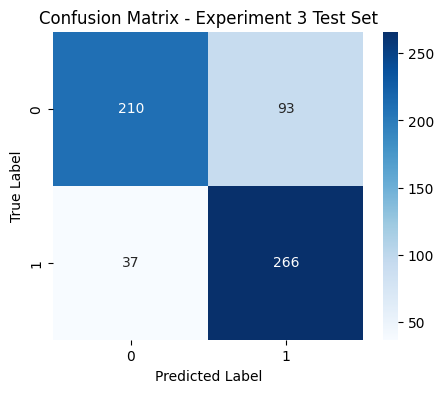

In [ ]:
preds_output = trainer_exp3.predict(tokenized_test)
preds = preds_output.predictions.argmax(axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Experiment 3 Test Set")
plt.show()

In this part of the code, I generate and visualize the confusion matrix for Experiment 3 using the test dataset. I start by getting the model’s prediction outputs with `trainer_exp3.predict()`, then extract the predicted labels by selecting the class with the highest score. I also pull the true labels so I can compare them directly. Using these two sets of labels, I compute a confusion matrix to see where the model predicted correctly and where it made mistakes. Finally, I plot the confusion matrix as a heatmap, giving me a clear visual representation of Experiment 3's classification performance.




---



In [ ]:
# After Experiment 3
print("\nSaving Experiment 3 model to Google Drive...")
model_exp3.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_3/')
tokenizer.save_pretrained('/content/drive/MyDrive/BERT_GEC_Models/experiment_3/')
print("Experiment 3 model saved successfully!")


Saving Experiment 3 model to Google Drive...
Experiment 3 model saved successfully!


In this part of my code, I’m saving the **trained BERT model and tokenizer from Experiment 3** to my Google Drive. I use the `save_pretrained()` function to store both the model’s parameters and configuration inside the folder `/content/drive/MyDrive/BERT_GEC_Models/experiment_3/`. I also save the tokenizer to make sure that when I reload the model later, it uses the same tokenization settings as during training. Finally, I print confirmation messages to indicate that the saving process was successful.




---



In [ ]:
import pandas as pd
from google.colab import files


results = [
    {'eval_loss': 0.9337813854217529, 'eval_accuracy': 0.7917355371900826, 'eval_precision': 0.7315789473684211, 'eval_recall': 0.9205298013245033, 'eval_f1': 0.8152492668621701, 'eval_runtime': 8.6047, 'eval_samples_per_second': 70.311, 'eval_steps_per_second': 35.213, 'epoch': 2.0},
{'eval_loss': 0.9957595467567444, 'eval_accuracy': 0.7871287128712872, 'eval_precision': 0.7289473684210527, 'eval_recall': 0.9141914191419142, 'eval_f1': 0.8111273792093704, 'eval_runtime': 4.8958, 'eval_samples_per_second': 123.78, 'eval_steps_per_second': 61.89, 'epoch': 2.0},
    {'eval_loss': 1.0325078964233398, 'eval_accuracy': 0.7851239669421488, 'eval_precision': 0.7429378531073446, 'eval_recall': 0.8708609271523179, 'eval_f1': 0.801829268292683, 'eval_runtime': 3.0735, 'eval_samples_per_second': 196.842, 'eval_steps_per_second': 98.584, 'epoch': 4.0},
{'eval_loss': 1.1264163255691528, 'eval_accuracy': 0.7607260726072608, 'eval_precision': 0.7135135135135136, 'eval_recall': 0.8712871287128713, 'eval_f1': 0.7845468053491828, 'eval_runtime': 6.1294, 'eval_samples_per_second': 98.868, 'eval_steps_per_second': 49.434, 'epoch': 4.0},
    {'eval_loss': 0.6504951119422913, 'eval_accuracy': 0.8132231404958677, 'eval_precision': 0.7441860465116279, 'eval_recall': 0.9536423841059603, 'eval_f1': 0.8359941944847605, 'eval_runtime': 2.894, 'eval_samples_per_second': 209.055, 'eval_steps_per_second': 52.523, 'epoch': 6.0},
{'eval_loss': 0.7907764911651611, 'eval_accuracy': 0.7755775577557755, 'eval_precision': 0.707196029776675, 'eval_recall': 0.9405940594059405, 'eval_f1': 0.8073654390934845, 'eval_runtime': 4.1436, 'eval_samples_per_second': 146.251, 'eval_steps_per_second': 36.684, 'epoch': 6.0},
]

# Create DataFrame
df_results = pd.DataFrame(results)

# Save to temporary files in Colab
df_results.to_csv('experiment_summary.csv', index=False)
df_results.to_excel('experiment_summary.xlsx', index=False)

print("Files created successfully!")
print("Downloading to your PC...")

# Download CSV to your PC
files.download('experiment_summary.csv')

# Download Excel to your PC
files.download('experiment_summary.xlsx')

print("Files downloaded to your PC!")

Files created successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded to your PC!


In this part of my code, I created a **summary table of all experiment results**, storing key metrics like loss, accuracy, precision, recall, and F1-score. I organized them into a Pandas DataFrame for easier viewing and analysis, then saved the data as both a **CSV and Excel file** named `experiment_summary`. Lastly, I used `files.download()` to automatically download the files to my computer for record-keeping and comparison.




---



# **Continuation for code here**